In [313]:
from google.colab import drive
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
import sys
import numpy as np
import tensorflow as tf
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [314]:
net_model = load_model('drive/My Drive/Colab Notebooks/model.h5')
net_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

### 主要程式碼 產生三張圖的adversarial版本圖片

1
Tensor("softmax_4/Softmax:0", shape=(None, 2), dtype=float32)
Tensor("strided_slice_59:0", shape=(), dtype=float32)
Tensor("gradients_55/conv1_pad_4/Pad_grad/Slice_1:0", shape=(None, 224, 224, 3), dtype=float32)

batch:1 Cost:9.0628802e-06%
batch:2 Cost:99.994123%


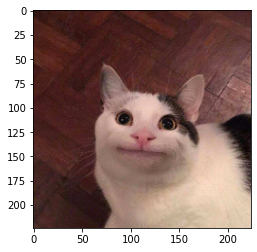

original image: [[9.999999e-01 9.062880e-08]]
adversarial image: [[6.2720007e-12 1.0000000e+00]]
adversarial is dog


1
Tensor("softmax_4/Softmax:0", shape=(None, 2), dtype=float32)
Tensor("strided_slice_60:0", shape=(), dtype=float32)
Tensor("gradients_56/conv1_pad_4/Pad_grad/Slice_1:0", shape=(None, 224, 224, 3), dtype=float32)

batch:1 Cost:0.00068382105%
batch:2 Cost:99.988234%


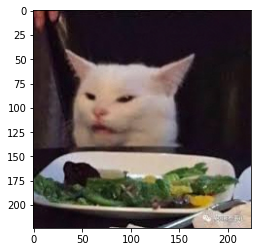

original image: [[9.9999321e-01 6.8382105e-06]]
adversarial image: [[2.2351715e-06 9.9999774e-01]]
adversarial is dog


0
Tensor("softmax_4/Softmax:0", shape=(None, 2), dtype=float32)
Tensor("strided_slice_61:0", shape=(), dtype=float32)
Tensor("gradients_57/conv1_pad_4/Pad_grad/Slice_1:0", shape=(None, 224, 224, 3), dtype=float32)

batch:1 Cost:0.0071541785%
batch:2 Cost:99.999917%


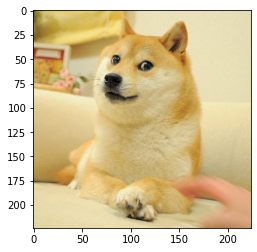

original image: [[7.1541785e-05 9.9992847e-01]]
adversarial image: [[9.9996138e-01 3.8614566e-05]]
adversarial is cat




In [315]:
cls_list = ['cat', 'dog']
files=['cat1', 'cat2', 'dog1']
for f in files:
    img = image.load_img('drive/My Drive/Colab Notebooks/'+f+'.png', target_size=(224, 224))    
    # recognize this image first and get label
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    pred = net_model.predict(x)[0]
    top_inds = pred.argsort()[::-1][:5]

    # get label and set adversarial label
    # 0 is cat, 1 is dog
    hacked_label = abs(1-top_inds[0])
    print(hacked_label)

    origin_img = image.img_to_array(img)
    hack_img = np.copy(origin_img)

    m_i_l = net_model.layers[0].input
    m_o_l = net_model.layers[-1].output
    print(m_o_l)

    cost_function = m_o_l[0,hacked_label]
    print(cost_function)
    gradient_function = K.gradients(cost_function, m_i_l)[0]
    print(gradient_function)
    grab_cost_and_gradients_from_model = K.function([m_i_l,K.learning_phase()], [cost_function, gradient_function])
    print(grab_cost_and_gradients_from_model, end="\n\n")

    e=0.8
    index=1
    cost = 0
    hack_img = np.expand_dims(hack_img, axis = 0)
    while cost < 0.6:
        cost, gradients = grab_cost_and_gradients_from_model([hack_img, 0])
        n=np.sign(gradients)
        hack_img += n*e
        print("batch:{} Cost:{:.8}%".format(index, cost*100))
        index +=1    

    tt = hack_img[0]+0.5*origin_img
    plt.imshow(image.array_to_img(tt))
    plt.show()

    ori = image.img_to_array(origin_img)
    ori=np.expand_dims(ori,axis=0)
    print("original image:", net_model.predict(ori))

    tt=image.img_to_array(tt)
    tt=np.expand_dims(tt,axis=0)
    pred=net_model.predict(tt)
    top_inds = pred[0].argsort()[::-1][:5]
    print("adversarial image:", pred, )
    print("adversarial is", cls_list[top_inds[0]], end="\n\n\n")

    # convert to img then save that
    hacked = image.array_to_img(tt[0])
    hacked.save("drive/My Drive/Colab Notebooks/"+f+"_hacked.png")

### 以下是測試用程式 分段落測試

In [277]:
img = image.load_img('drive/My Drive/Colab Notebooks/'+f+'.png', target_size=(224, 224))

# 0是貓 1是狗
hacked_label = 0

origin_img = image.img_to_array(img)
hack_img = np.copy(origin_img)

m_i_l = net_model.layers[0].input
m_o_l = net_model.layers[-1].output
print(m_o_l)

cost_function = m_o_l[0,hacked_label]
print(cost_function)
gradient_function = K.gradients(cost_function, m_i_l)[0]
print(gradient_function)
grab_cost_and_gradients_from_model = K.function([m_i_l,K.learning_phase()], [cost_function, gradient_function])

Tensor("softmax_2/Softmax:0", shape=(None, 2), dtype=float32)
Tensor("strided_slice_44:0", shape=(), dtype=float32)
Tensor("gradients_38/conv1_pad_2/Pad_grad/Slice_1:0", shape=(None, 224, 224, 3), dtype=float32)


In [278]:
e=0.8
index=1
cost = 0
hack_img = np.expand_dims(hack_img, axis = 0)
while cost < 0.6:
    cost, gradients = grab_cost_and_gradients_from_model([hack_img, 0])
    n=np.sign(gradients)
    hack_img += n*e
    # break
    # hack_img = np.clip(hack_img, max_change_below, max_change_above)
    # hack_img = np.clip(hack_img, -1.0, 1.0)
    print("batch:{} Cost:{:.8}%".format(index, cost*100))
    index +=1

batch:1 Cost:0.0071541785%
batch:2 Cost:99.999917%


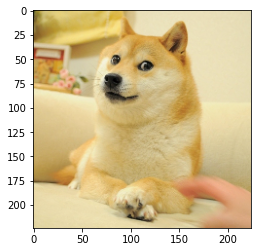

In [279]:
plt.figure()
tt = hack_img[0]+0.5*origin_img
plt.imshow(image.array_to_img(hack_img[0]+origin_img))
plt.show()


In [280]:
ori = image.img_to_array(origin_img)
ori=np.expand_dims(ori,axis=0)
print(net_model.predict(ori))

tt=image.img_to_array(tt)
tt=np.expand_dims(tt,axis=0)
print(net_model.predict(tt))


[[7.1541785e-05 9.9992847e-01]]
[[9.9996138e-01 3.8614566e-05]]


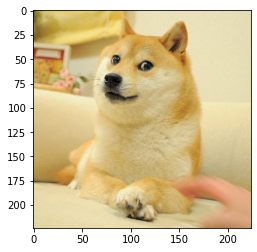

In [281]:
hacked = image.array_to_img(tt[0])
plt.imshow(hacked)
hacked.save("drive/My Drive/Colab Notebooks/dog1_hacked.png")

### 下列是原始predict.py程式碼

In [317]:
from keras.preprocessing import image

cls_list = ['cat', 'dog']
files = ['drive/My Drive/Colab Notebooks/cat1.png', 'drive/My Drive/Colab Notebooks/cat1_hacked.png', 'drive/My Drive/Colab Notebooks/cat2.png', 'drive/My Drive/Colab Notebooks/cat2_hacked.png', 'drive/My Drive/Colab Notebooks/dog1.png', 'drive/My Drive/Colab Notebooks/dog1_hacked.png']
for f in files:
    img = image.load_img(f, target_size=(224, 224))
    if img is None:
        continue
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    pred = net_model.predict(x)[0]
    top_inds = pred.argsort()[::-1][:5]
    print(f,' is ',cls_list[top_inds[0]])
    for i in top_inds:
        print('    {:.3f}  {}'.format(pred[i], cls_list[i]))
    print()

drive/My Drive/Colab Notebooks/cat1.png  is  cat
    1.000  cat
    0.000  dog

drive/My Drive/Colab Notebooks/cat1_hacked.png  is  dog
    1.000  dog
    0.000  cat

drive/My Drive/Colab Notebooks/cat2.png  is  cat
    1.000  cat
    0.000  dog

drive/My Drive/Colab Notebooks/cat2_hacked.png  is  dog
    1.000  dog
    0.000  cat

drive/My Drive/Colab Notebooks/dog1.png  is  dog
    1.000  dog
    0.000  cat

drive/My Drive/Colab Notebooks/dog1_hacked.png  is  cat
    1.000  cat
    0.000  dog

